These are data containing all the traces contained in the 'Kolumbo box' described in my thesis. In particular, there are no additional offset-constraints or hand-picked trace-removal.

#### Notebook config

In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2

In [27]:
import fwipy 
from fwipy import *
from fwipy.config.logging import *
from fwipy.ioapi.segy import SgyFile
lll(40)

In [8]:
help(fwipy)

Help on package fwipy:

NAME
    fwipy

PACKAGE CONTENTS
    config (package)
    dsp (package)
    fd (package)
    fwi (package)
    generic (package)
    ioapi (package)
    ndat (package)
    numeric (package)
    plot (package)
    project (package)
    seismic (package)
    utils

FILE
    /home/kajetan/software/Kolumbo-FWI/fwipy/__init__.py




#### Developing wiggle plots

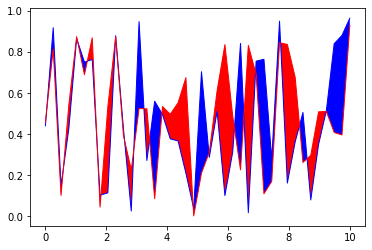

In [47]:
# plot_2_series 
from fwipy.utils import plot_2_series
ns = 40
x = np.linspace(0,10,ns)
y1 = np.random.rand(ns)
y2 = np.random.rand(ns)
plot_2_series(x, y1, y2)

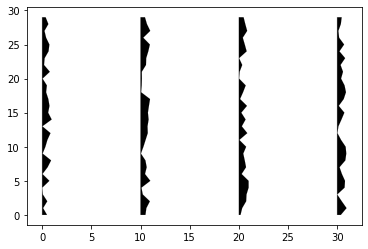

In [57]:
# plot_wiggles
from fwipy.utils import plot_wiggles
Z = np.random.rand(4,1,30)
plot_wiggles(Z)

#### Example lines

In [58]:
tracf = 4112
ep = 8

# Field data
Filtered as in the PhD thesis.

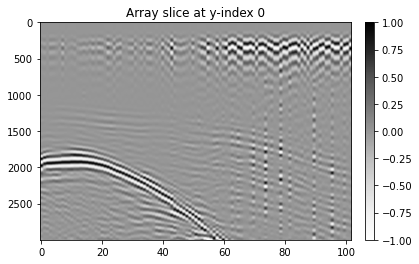

In [75]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_field_filtered.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgyobs = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the starting model.

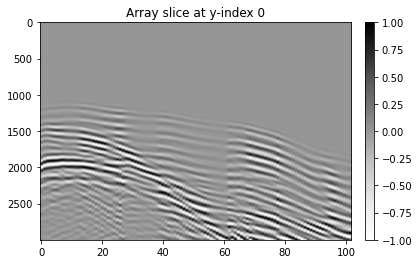

In [71]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_synth_it000.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy000 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

In [116]:
a1.shape

(103, 3000)

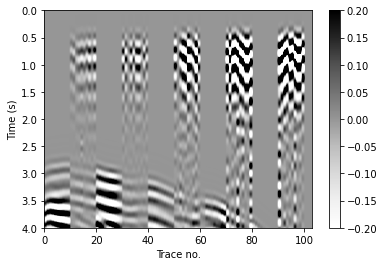

In [145]:
def compare_data(sgy1, sgy2, tracf, ep, dt=0.0025, cmap='Greys', tmin=None, tmax=None,
                vmin=None, vmax=None):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    t1 = 0
    t2 = a1.shape[-1] * dt
    x1 = 0
    x2 = a1.shape[0]
    a = interleave_arrays(a1, a2)
    plt.imshow(a.T, aspect='auto', extent=[x1, x2, t2, t1],
               cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel('Trace no.')
    plt.ylabel('Time (s)')
    plt.ylim(tmax, tmin)
compare_data(sgy000, sgyobs, tracf, ep, tmin=0, tmax=4, vmin=-.2, vmax=.2)    

(2000.0, 0.0)

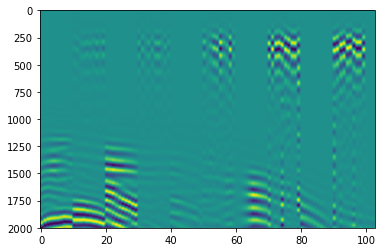

In [124]:


a = interleave_arrays(a1, a2)


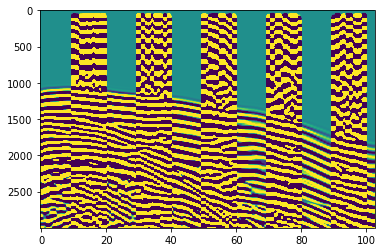

In [94]:
# plot example line 
a1 = sgy000.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

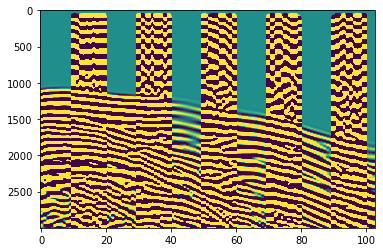

In [95]:
# plot example line 
a1 = sgy020.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

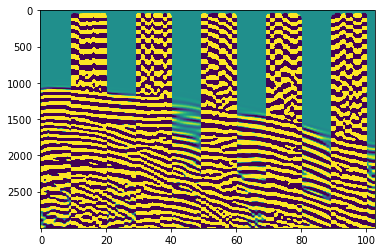

In [97]:
# plot example line 
a1 = sgy080.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

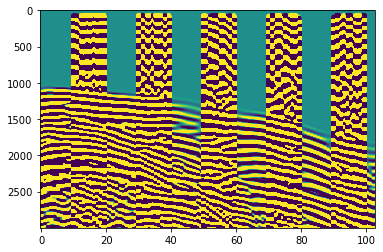

In [99]:
# plot example line 
a1 = sgy160.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

# Synthetics
From the model after 020 iterations.

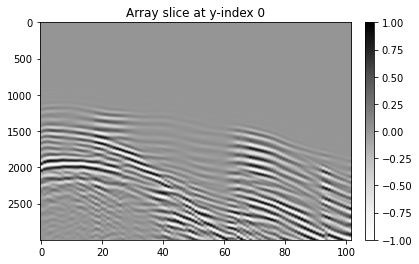

In [93]:
# plot example line 
file_name = 'p14it020syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy020 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 080 iterations.

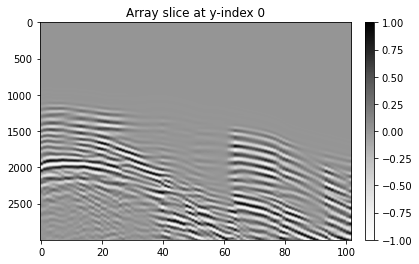

In [96]:
# plot example line 
file_name = 'p14it080syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy080 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 160 iterations.

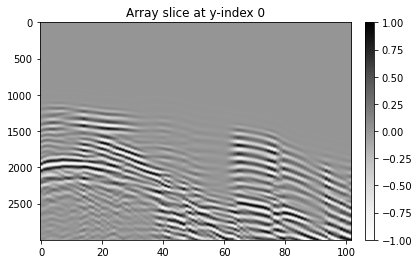

In [98]:
# plot example line 
file_name = 'p14it160syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy160 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# ...